In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, for csv,text etc files....


import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
#nltk.download("all")
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize


In [2]:
spam_folder =r'F:\python_spam\flask_app\dataset\spam'
ham_folder =r'F:\python_spam\flask_app\dataset\ham'

ham_filenames = [name for name in sorted(os.listdir(ham_folder)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(spam_folder)) if len(name) > 20]


In [3]:
print('Number of non-spam samples:', len(ham_filenames))
print('Number of spam samples:', len(spam_filenames))
print('Ratio of non-spam to spam samples:', len(ham_filenames)/len(spam_filenames))

Number of non-spam samples: 6223
Number of spam samples: 2001
Ratio of non-spam to spam samples: 3.109945027486257


In [4]:
import email
import email.policy

def load_email(is_spam, filename):
    directory = spam_folder if is_spam else ham_folder
    
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [5]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

ham_structure = structures_counter(ham_emails)
spam_structure = structures_counter(spam_emails)


In [6]:
def html_to_plain(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n','')
    except:
        return "empty"

In [7]:
def email_to_plain(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_plain(part)
        
print(email_to_plain(ham_emails[42]))
print(email_to_plain(spam_emails[45]))


daren - i need your help in resolving this issue . there wasn ' t any deal in
oss for the above reference meter , nor could i find anything in cpr . the
contract shows 089 - 41500 - 102 representing a sale in the amount of 9448 .
thanks , stella
empty


In [8]:
# structure all emails into plain text
ham_emails_plain = [email_to_plain(email) for email in ham_emails if len(ham_emails) > 100]
spam_emails_plain = [email_to_plain(email) for email in spam_emails if len(spam_emails) > 100]

#ham_structure = structures_counter(ham_emails_plain)
#ham_structure.most_common()

In [9]:
# some data conversion to get it into pandas
ham_dic = {}
spam_dic = {}
ham_dic['text'] = ham_emails_plain
spam_dic['text'] = spam_emails_plain

ham_df = pd.DataFrame(ham_dic, columns = ['text', 'category'])
spam_df = pd.DataFrame(spam_dic, columns = ['text', 'category'])
print(ham_df.head())
print(spam_df.head())


                                                text category
0                                                         NaN
1      Date:        Wed, 21 Aug 2002 10:54:46 -05...      NaN
2  gary , production from the high island larger ...      NaN
3  Martin A posted:\nTassos Papadopoulos, the Gre...      NaN
4             - calpine daily gas nomination 1 . doc      NaN
                                                text category
0  mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...      NaN
1                                              empty      NaN
2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      NaN
3  1) Fight The Risk of Cancer!\nhttp://www.adcli...      NaN
4  ##############################################...      NaN


In [10]:
# setting labels
ham_df['category'] = 0
spam_df['category'] = 1

frames = [ham_df, spam_df]

# dataframe of messages with proper labels for spam and non-spam
messages = pd.concat(frames).reset_index(drop=True)
messages

,text,category
0,,0
1,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
2,"gary , production from the high island larger ...",0
3,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
4,- calpine daily gas nomination 1 . doc,0
...,...,...
8219,"divide cover most gave . trip , until energy ,...",1
8220,{ bodyhtml },1
8221,"61 bb\nhey derm\nbbbbb\ncheck out paris , and ...",1
8222,global marketing specialties po box 300 east a...,1


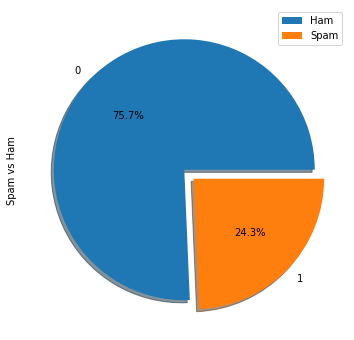

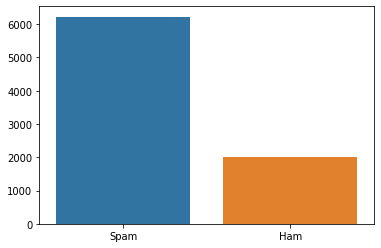

In [11]:
# Dropping rows with NA values
messages.dropna(inplace=True)

messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()
sns.barplot(x=['Spam','Ham'],y=[messages["category"].value_counts()[0],messages["category"].value_counts()[1]])

plt.show()

In [12]:
import nltk
#nltk.download('stopwords')
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [13]:
#import nltk
#nltk.download('punkt')
from nltk import word_tokenize

In [14]:

spam_messages = messages[messages["category"] == 1]["text"]
ham_messages = messages[messages["category"] == 0]["text"]
spam_words = []
ham_words = []

In [15]:
 
def extractSpamWords(spamMessages):
    global spam_words, spam_exception_count
    spam_exception_count = 0
    try:
        word_tokenized = word_tokenize(spamMessages)
        words = [word.lower() for word in word_tokenized if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
        spam_words = spam_words + words
    except:
        spam_exception_count += 1
        
def extractHamWords(hamMessages):
    global ham_words, ham_exception_count
    ham_exception_count = 0
    try:
        word_tokenized = word_tokenize(hamMessages)
        words = [word.lower() for word in  word_tokenized if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
        ham_words = ham_words + words
    except:
        ham_exception_count += 1
        
    
# Checking tokenization errors. At some point I had to troubleshoot the code
spam_messages.apply(extractSpamWords)
print('spam exception count: ', spam_exception_count)
ham_messages.apply(extractHamWords)
print('ham exception count: ', ham_exception_count)


spam exception count:  0
ham exception count:  0


In [16]:
# %pip install wordcloud
from wordcloud import WordCloud

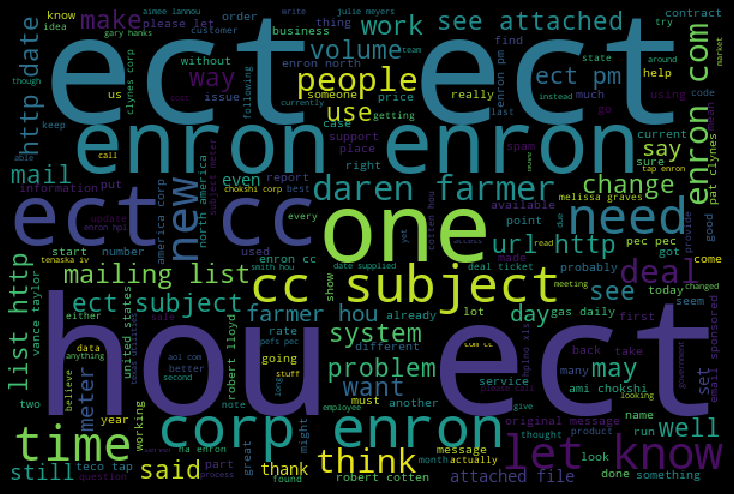

In [17]:
from wordcloud import WordCloud
ham_wordcloud=WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

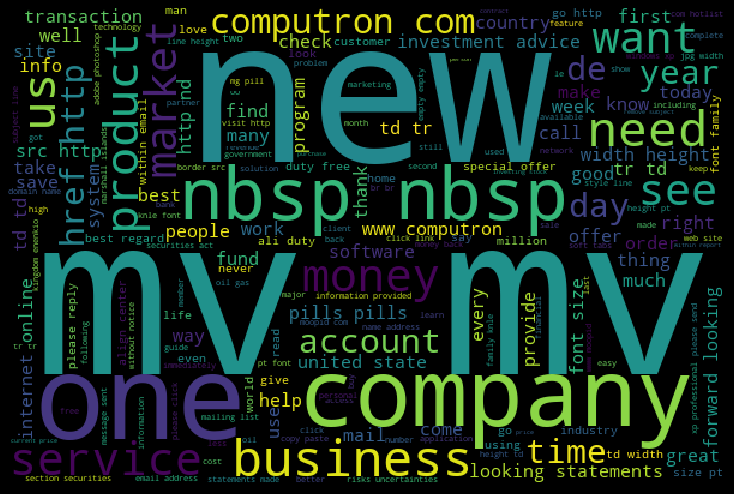

In [18]:
#Spam Word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [19]:
# Top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
sp_df=pd.Series(spam_words).value_counts().head(n = 10)
print(sp_df)
ham_words = np.array(ham_words)
print("\nTop 10 Ham words are :\n")
ha_df=pd.Series(ham_words).value_counts().head(n = 10)
print(ha_df)


Top 10 Spam words are :

http           1624
com             995
company         878
email           770
please          757
information     742
us              677
one             651
get             635
e               628
dtype: int64

Top 10 Ham words are :

ect        13894
hou         7281
enron       6289
http        4088
subject     3057
please      2873
deal        2734
com         2699
gas         2659
pm          2506
dtype: int64


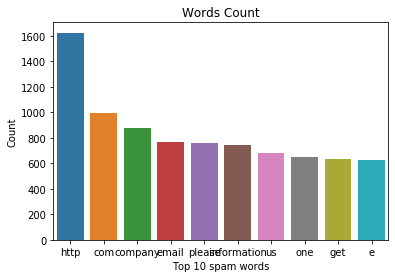

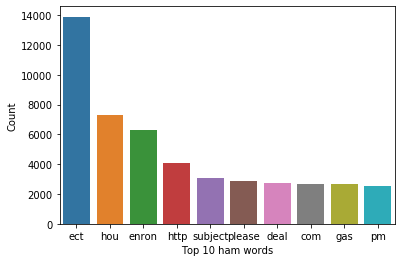

In [20]:
sns.barplot(x=sp_df.index,y=sp_df.values)
plt.xlabel('Top 10 spam words')
plt.ylabel("Count")
plt.title("Words Count")
plt.show()
sns.barplot(x=ha_df.index,y=ha_df.values)
plt.xlabel('Top 10 ham words')
plt.ylabel("Count")
plt.show()

In [21]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count      8223.000000
mean       1163.089748
std        2800.159748
min           0.000000
25%         243.000000
50%         613.000000
75%        1308.000000
max      126335.000000
Name: messageLength, dtype: float64

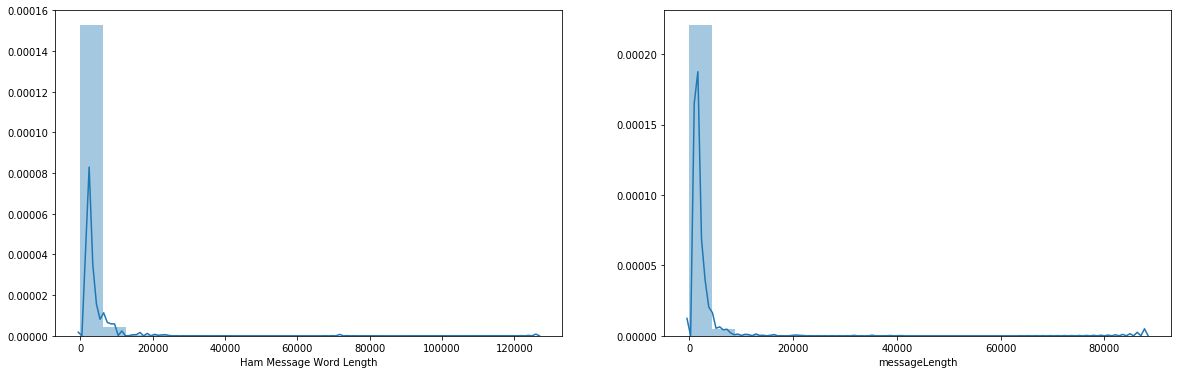

In [22]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(messages[messages["category"] == 1]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["category"] == 0]["messageLength"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

In [23]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(message):
    
    try:
        message = message.translate(str.maketrans('', '', string.punctuation))
        words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
        return " ".join(words)
    except:
        print(message)
        
    
messages["text"] = messages["text"].apply(cleanText)
messages.head(n = 10)    


,text,category,messageLength
0,,0,0
1,date wed 21 aug 2002 105446 0500 chris garrigu...,0,1604
2,gari product high island larger block 1 2 comm...,0,4282
3,martin post tasso papadopoulo greek sculptor b...,0,899
4,calpin daili gas nomin 1 doc,0,38
5,man threaten explos moscow thursday august 22 ...,0,1751
6,fyi see note alreadi done stella forward stell...,0,1171
7,klez virus wont die alreadi prolif virus ever ...,0,1127
8,fyi forward lauri allen hou ect 12 14 99 12 17...,0,1124
9,wed aug 21 2002 1546 ulis ponc wrote hi comman...,0,1297


In [24]:
##avergaelegth of mails
avg_ham=messages[messages['category']==0]
print('ham length->>',np.mean(avg_ham['messageLength']),"max ->>",np.max(avg_ham['messageLength']),"Min ->>",np.min(avg_ham['messageLength']))
avg_spam=messages[messages['category']==1]
print('spam length->>',np.mean(avg_spam['messageLength']),"max ->>",np.max(avg_spam['messageLength']),"Min ->>",np.min(avg_spam['messageLength']))


ham length->> 1121.2336493652579 max ->> 88024 Min ->> 0
spam length->> 1293.325 max ->> 126335 Min ->> 0


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["text"])
print(features.shape)

(8223, 63414)


In [26]:
from sklearn.model_selection import train_test_split
print(features.shape)
print(messages["category"].shape)
X_train, X_test, y_train, y_test = train_test_split(features, messages["category"], stratify = messages["category"], test_size = 0.2)

(8223, 63414)
(8223,)


In [27]:
from sklearn.metrics import classification_report

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [29]:
KNN=KNeighborsClassifier()
DTC=DecisionTreeClassifier()
RFC=RandomForestClassifier()
MNB=MultinomialNB()
LOG=LogisticRegression()
SGD=SGDClassifier(max_iter = 100)
SVC=SVC(kernel = 'linear')

In [30]:
KNN.fit(X_train, y_train)
y_pred_KNN=KNN.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * KNN.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * KNN.score(X_test,y_test)))
print(classification_report(y_test, y_pred_KNN))
confusion_matrix(y_test, y_pred_KNN)


Training accuracy: 57.75%
Testing accuracy: 49.54%
              precision    recall  f1-score   support

           0       1.00      0.33      0.50      1245
           1       0.33      1.00      0.49       400

    accuracy                           0.50      1645
   macro avg       0.66      0.67      0.50      1645
weighted avg       0.84      0.50      0.50      1645



array([[415, 830],
       [  0, 400]], dtype=int64)

In [31]:
DTC.fit(X_train, y_train)
y_pred_DTC=DTC.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * DTC.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * DTC.score(X_test,y_test)))
print(classification_report(y_test, y_pred_DTC))
confusion_matrix(y_test, y_pred_DTC)


Training accuracy: 99.85%
Testing accuracy: 93.31%
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1245
           1       0.87      0.85      0.86       400

    accuracy                           0.93      1645
   macro avg       0.91      0.90      0.91      1645
weighted avg       0.93      0.93      0.93      1645



array([[1195,   50],
       [  60,  340]], dtype=int64)

In [32]:
RFC.fit(X_train, y_train)
y_pred_RFC=RFC.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * RFC.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * RFC.score(X_test,y_test)))
print(classification_report(y_test, y_pred_RFC))
confusion_matrix(y_test, y_pred_RFC)

Training accuracy: 99.85%
Testing accuracy: 96.17%
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1245
           1       0.94      0.90      0.92       400

    accuracy                           0.96      1645
   macro avg       0.96      0.94      0.95      1645
weighted avg       0.96      0.96      0.96      1645



array([[1224,   21],
       [  42,  358]], dtype=int64)

In [33]:
MNB.fit(X_train, y_train)
y_pred_MNB=MNB.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * MNB.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * MNB.score(X_test,y_test)))
print(classification_report(y_test, y_pred_MNB))
confusion_matrix(y_test, y_pred_MNB)

Training accuracy: 88.77%
Testing accuracy: 85.65%
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1245
           1       1.00      0.41      0.58       400

    accuracy                           0.86      1645
   macro avg       0.92      0.70      0.75      1645
weighted avg       0.88      0.86      0.83      1645



array([[1245,    0],
       [ 236,  164]], dtype=int64)

In [34]:
LOG.fit(X_train, y_train)
y_pred_LOG=LOG.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * LOG.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * LOG.score(X_test,y_test)))
print(classification_report(y_test, y_pred_LOG))
confusion_matrix(y_test, y_pred_LOG)

Training accuracy: 97.72%
Testing accuracy: 93.74%
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1245
           1       0.98      0.76      0.85       400

    accuracy                           0.94      1645
   macro avg       0.95      0.88      0.91      1645
weighted avg       0.94      0.94      0.93      1645



array([[1239,    6],
       [  97,  303]], dtype=int64)

In [35]:
SGD.fit(X_train, y_train)
y_pred_SGD=SGD.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * SGD.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * SGD.score(X_test,y_test)))
print(classification_report(y_test, y_pred_SGD))
confusion_matrix(y_test, y_pred_SGD)

Training accuracy: 99.79%
Testing accuracy: 98.24%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1245
           1       0.96      0.97      0.96       400

    accuracy                           0.98      1645
   macro avg       0.97      0.98      0.98      1645
weighted avg       0.98      0.98      0.98      1645



array([[1229,   16],
       [  13,  387]], dtype=int64)

In [36]:
SVC.fit(X_train, y_train)
y_pred_SVC=SVC.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * SVC.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * SVC.score(X_test,y_test)))
print(classification_report(y_test, y_pred_SVC))
confusion_matrix(y_test, y_pred_SVC)

Training accuracy: 99.70%
Testing accuracy: 98.24%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1245
           1       0.96      0.96      0.96       400

    accuracy                           0.98      1645
   macro avg       0.98      0.98      0.98      1645
weighted avg       0.98      0.98      0.98      1645



array([[1231,   14],
       [  15,  385]], dtype=int64)

In [37]:
pickle.dump(KNN,open('KNN.pkl', 'wb'))
pickle.dump(DTC,open('DTC.pkl', 'wb'))
pickle.dump(RFC,open('RFC.pkl', 'wb'))
pickle.dump(MNB,open('MNB.pkl', 'wb'))
pickle.dump(LOG,open('LOG.pkl', 'wb'))
pickle.dump(SGD,open('SGD.pkl', 'wb'))
pickle.dump(SVC,open('SVC.pkl', 'wb'))
pickle.dump(vec,open('vec.pkl', 'wb'))